In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import warnings
import datetime
from datetime import timedelta, time
import statistics
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/consolidado.csv


In [2]:
data = pd.read_csv("/kaggle/input/consolidado.csv", sep=";")

In [3]:
#Se filtran los clientes que tienen información completa del 99% en adelante
clientes = ["DATOSCLIENTE1.csv","DATOSCLIENTE2.csv","DATOSCLIENTE3.csv","DATOSCLIENTE4.csv",
            "DATOSCLIENTE5.csv","DATOSCLIENTE6.csv","DATOSCLIENTE7.csv","DATOSCLIENTE8.csv","DATOSCLIENTE9.csv",
            "DATOSCLIENTE10.csv","DATOSCLIENTE16.csv","DATOSCLIENTE17.csv","DATOSCLIENTE18.csv",
            "DATOSCLIENTE19.csv","DATOSCLIENTE20.csv"]

data = data[data['Archivo'].isin(clientes)]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294310 entries, 0 to 463424
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Fecha            294310 non-null  object 
 1   Active_energy    294310 non-null  float64
 2   Reactive_energy  294310 non-null  float64
 3   Voltaje_FA       294310 non-null  float64
 4   Voltaje_FC       294310 non-null  float64
 5   Archivo          294310 non-null  object 
dtypes: float64(4), object(2)
memory usage: 15.7+ MB


In [5]:
data_clean = data.copy()
data_clean['Fecha_hora'] = pd.to_datetime(data_clean['Fecha'])
data_clean['Energia_activa'] = data_clean.Active_energy
data_clean['Energia_reactiva'] = data_clean.Reactive_energy
data_clean.drop('Active_energy', axis=1, inplace=True)
data_clean.drop('Reactive_energy', axis=1, inplace=True)
data_clean['Fecha'] = data_clean['Fecha_hora'].dt.date
data_clean['Hora'] = data_clean['Fecha_hora'].dt.time
dayname = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
data_clean['Dia_semana'] = pd.to_datetime(data_clean['Fecha']).dt.dayofweek.apply(lambda x: dayname[x])

data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 294310 entries, 0 to 463424
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Fecha             294310 non-null  object        
 1   Voltaje_FA        294310 non-null  float64       
 2   Voltaje_FC        294310 non-null  float64       
 3   Archivo           294310 non-null  object        
 4   Fecha_hora        294310 non-null  datetime64[ns]
 5   Energia_activa    294310 non-null  float64       
 6   Energia_reactiva  294310 non-null  float64       
 7   Hora              294310 non-null  object        
 8   Dia_semana        294310 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 22.5+ MB


In [6]:
# Cleaning duplicates for each client
def clean_duplicates_by_client(df):
    # Group by 'Archivo' (cliente) and 'Datetime', and count occurrences
    datetime_counts = df.groupby(['Archivo', 'Fecha_hora']).size()

    # Filter to find where counts are greater than 1
    duplicates = datetime_counts[datetime_counts > 1]

    # Print the result for each client
    for client, counts in duplicates.groupby(level=0):
        print(f"Duplicados de {client}:")
        print(counts)
    # Check for clients without duplicates
    unique_clients = df['Archivo'].unique()
    for client in unique_clients:
        if client not in duplicates.index:
            print(f"No se encontraron duplicados para el {client}")

# Apply the function to the entire dataframe
clean_duplicates_by_client(data_clean)

No se encontraron duplicados para el DATOSCLIENTE1.csv
No se encontraron duplicados para el DATOSCLIENTE10.csv
No se encontraron duplicados para el DATOSCLIENTE16.csv
No se encontraron duplicados para el DATOSCLIENTE17.csv
No se encontraron duplicados para el DATOSCLIENTE18.csv
No se encontraron duplicados para el DATOSCLIENTE19.csv
No se encontraron duplicados para el DATOSCLIENTE2.csv
No se encontraron duplicados para el DATOSCLIENTE20.csv
No se encontraron duplicados para el DATOSCLIENTE3.csv
No se encontraron duplicados para el DATOSCLIENTE4.csv
No se encontraron duplicados para el DATOSCLIENTE5.csv
No se encontraron duplicados para el DATOSCLIENTE6.csv
No se encontraron duplicados para el DATOSCLIENTE7.csv
No se encontraron duplicados para el DATOSCLIENTE8.csv
No se encontraron duplicados para el DATOSCLIENTE9.csv


In [7]:
# Contar el tamaño de cada grupo por fecha para cada cliente
def count_by_date_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Imprimir el tamaño de cada grupo por fecha para el cliente actual
        print(f"Tamaño de cada grupo por fecha para el cliente {client}:")
        print(group.groupby("Fecha").size())

# Aplicar la función al dataframe completo
count_by_date_for_each_client(data_clean)

Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE1.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-28    24
2023-03-29    24
2023-03-30    24
2023-03-31    24
2023-04-01     1
Length: 821, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE10.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-28    24
2023-03-29    24
2023-03-30    24
2023-03-31    24
2023-04-01     1
Length: 821, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE16.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
2021-01-05    24
              ..
2023-03-20    24
2023-03-21    24
2023-03-22    24
2023-03-23    24
2023-03-24    12
Length: 813, dtype: int64
Tamaño de cada grupo por fecha para el cliente DATOSCLIENTE17.csv:
Fecha
2021-01-01    24
2021-01-02    24
2021-01-03    24
2021-01-04    24
20

In [8]:
# Función para contar el tamaño de cada grupo por hora para cada cliente
def count_by_time_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Imprimir el tamaño de cada grupo por hora para el cliente actual
        print(f"Tamaño de cada grupo por hora para el cliente {client}:")
        print(group.groupby("Hora").size())

# Aplicar la función al dataframe completo
count_by_time_for_each_client(data_clean)

Tamaño de cada grupo por hora para el cliente DATOSCLIENTE1.csv:
Hora
00:00:00    821
01:00:00    820
02:00:00    820
03:00:00    820
04:00:00    820
05:00:00    820
06:00:00    820
07:00:00    820
08:00:00    820
09:00:00    820
10:00:00    820
11:00:00    820
12:00:00    820
13:00:00    820
14:00:00    820
15:00:00    820
16:00:00    820
17:00:00    820
18:00:00    820
19:00:00    820
20:00:00    820
21:00:00    820
22:00:00    820
23:00:00    820
dtype: int64
Tamaño de cada grupo por hora para el cliente DATOSCLIENTE10.csv:
Hora
00:00:00    821
01:00:00    820
02:00:00    820
03:00:00    820
04:00:00    820
05:00:00    820
06:00:00    820
07:00:00    820
08:00:00    820
09:00:00    820
10:00:00    820
11:00:00    820
12:00:00    820
13:00:00    820
14:00:00    820
15:00:00    820
16:00:00    820
17:00:00    820
18:00:00    820
19:00:00    820
20:00:00    820
21:00:00    820
22:00:00    820
23:00:00    820
dtype: int64
Tamaño de cada grupo por hora para el cliente DATOSCLIENTE16.csv:

In [9]:
# Función para eliminar las fechas con menos de 24 registros por cliente
def remove_dates_below_24(df):
    # Lista para almacenar los índices de las filas a eliminar
    rows_to_drop = []
    
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Group by 'Fecha' and count the records for each date
        grouped = group.groupby("Fecha").size()
        
        # Filtrar las fechas con menos de 24 registros
        dates_below_24 = grouped[grouped < 24]
        
        # Obtener los índices de las filas con esas fechas
        for date in dates_below_24.index:
            rows_to_drop.extend(group[group['Fecha'] == date].index)
    
    # Eliminar las filas con fechas que tienen menos de 24 registros
    df_cleaned = df.drop(rows_to_drop)
    
    return df_cleaned

# Aplicar la función al dataframe completo
data_clean_filtered = remove_dates_below_24(data_clean)

In [10]:
# Función para convertir la columna 'Energia_activa' a tipo numérico para cada cliente
def convert_to_numeric_for_each_client(df):
    # Iterar sobre cada cliente
    for client, group in df.groupby('Archivo'):
        # Convertir la columna 'Energia_activa' a tipo numérico
        df.loc[group.index, 'Energia_activa'] = pd.to_numeric(group['Energia_activa'], errors='coerce')

# Aplicar la función al dataframe completo
convert_to_numeric_for_each_client(data_clean_filtered)

In [11]:
# Lista para almacenar los DataFrames individuales de cada cliente
dfs_por_cliente = []

# Iterar sobre cada cliente
for cliente, df_cliente in data_clean_filtered.groupby('Archivo'):
    # Crear un DataFrame para el cliente actual con las columnas 'Fecha_hora' y 'Energia_activa'
    df_cliente_individual = df_cliente[['Fecha_hora', 'Energia_activa']]
    # Establecer 'Fecha_hora' como el índice del DataFrame
    df_cliente_individual = df_cliente_individual.set_index('Fecha_hora')
    # Agregar el DataFrame del cliente actual a la lista
    dfs_por_cliente.append((cliente, df_cliente_individual))

# Imprimir los primeros registros de cada DataFrame
for cliente, df_cliente in dfs_por_cliente:
    print(f"DataFrame para el cliente: {cliente}")
    print(df_cliente.head())
    print()

DataFrame para el cliente: DATOSCLIENTE1.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        0.357841
2021-01-01 01:00:00        0.372264
2021-01-01 02:00:00        1.044687
2021-01-01 03:00:00        0.566425
2021-01-01 04:00:00        1.080556

DataFrame para el cliente: DATOSCLIENTE10.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        2.873046
2021-01-01 01:00:00        2.037791
2021-01-01 02:00:00        2.358945
2021-01-01 03:00:00        1.347161
2021-01-01 04:00:00        2.486699

DataFrame para el cliente: DATOSCLIENTE16.csv
                     Energia_activa
Fecha_hora                         
2021-01-01 00:00:00        0.020158
2021-01-01 01:00:00        0.231000
2021-01-01 02:00:00        0.014679
2021-01-01 03:00:00        0.191819
2021-01-01 04:00:00        0.660391

DataFrame para el cliente: DATOSCLIENTE17.csv
                     Energia_activa
Fecha_hora            

In [12]:
##grupo1: 1,2,3,4,5; Grupo2: 6,7,8,10; Grupo3: 9,16,17,18,19,20 
df_cliente1_idx = dfs_por_cliente[0]
df_cliente6_idx = dfs_por_cliente[11]
df_cliente17_idx = dfs_por_cliente[3]

df_cliente1_idx = df_cliente1_idx[1]
df_cliente6_idx = df_cliente6_idx[1]
df_cliente17_idx = df_cliente17_idx[1]

df_cliente1 = df_cliente1_idx.reset_index()
df_cliente6 = df_cliente6_idx.reset_index()
df_cliente17 = df_cliente17_idx.reset_index()

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error

In [14]:
train_size1 = int(len(df_cliente1_idx) * 0.9)
train1, test1 = df_cliente1_idx.iloc[0:train_size1], df_cliente1_idx.iloc[train_size1:len(df_cliente1_idx)]
print("Train size for df_cliente1:", len(train1), "Test size for df_cliente1:", len(test1))

Train size for df_cliente1: 17712 Test size for df_cliente1: 1968


In [15]:
print('Training data shape: ', train1.shape)
print('Test data shape: ', test1.shape)

Training data shape:  (17712, 1)
Test data shape:  (1968, 1)


In [16]:
scaler = MinMaxScaler()
train1 = scaler.fit_transform(train1)
train1

array([[0.05457954],
       [0.05679003],
       [0.15984493],
       ...,
       [0.23076186],
       [0.21641074],
       [0.26381938]])

In [17]:
scaler = MinMaxScaler()
test1 = scaler.fit_transform(test1)
test1

array([[0.64444269],
       [0.62331481],
       [0.48176068],
       ...,
       [0.6257132 ],
       [0.43721732],
       [0.43844695]])

In [18]:
# Selecting the timesteps

timesteps=18

In [19]:
# Converting data to 2D tensor

train_data_timesteps1=np.array([[j for j in train1[i:i+timesteps]] for i in range(0,len(train1)-timesteps+1)])[:,:,0]
train_data_timesteps1.shape

(17695, 18)

In [20]:
print(train_data_timesteps1[0:5])

[[0.05457954 0.05679003 0.15984493 0.08654687 0.16534224 0.11663702
  0.19876642 0.23963936 0.23615813 0.18628185 0.1783109  0.26353044
  0.2308729  0.19579556 0.18768225 0.25849976 0.16585288 0.18354035]
 [0.05679003 0.15984493 0.08654687 0.16534224 0.11663702 0.19876642
  0.23963936 0.23615813 0.18628185 0.1783109  0.26353044 0.2308729
  0.19579556 0.18768225 0.25849976 0.16585288 0.18354035 0.21324705]
 [0.15984493 0.08654687 0.16534224 0.11663702 0.19876642 0.23963936
  0.23615813 0.18628185 0.1783109  0.26353044 0.2308729  0.19579556
  0.18768225 0.25849976 0.16585288 0.18354035 0.21324705 0.25863476]
 [0.08654687 0.16534224 0.11663702 0.19876642 0.23963936 0.23615813
  0.18628185 0.1783109  0.26353044 0.2308729  0.19579556 0.18768225
  0.25849976 0.16585288 0.18354035 0.21324705 0.25863476 0.23508435]
 [0.16534224 0.11663702 0.19876642 0.23963936 0.23615813 0.18628185
  0.1783109  0.26353044 0.2308729  0.19579556 0.18768225 0.25849976
  0.16585288 0.18354035 0.21324705 0.25863476

In [21]:
# Converting test data to 2D tensor

test_data_timesteps1=np.array([[j for j in test1[i:i+timesteps]] for i in range(0,len(test1)-timesteps+1)])[:,:,0]
test_data_timesteps1.shape

(1951, 18)

In [22]:
x_train1, y_train1 = train_data_timesteps1[:,:timesteps-1],train_data_timesteps1[:,[timesteps-1]]
x_test1, y_test1 = test_data_timesteps1[:,:timesteps-1],test_data_timesteps1[:,[timesteps-1]]

print(x_train1.shape, y_train1.shape)
print(x_test1.shape, y_test1.shape)

(17695, 17) (17695, 1)
(1951, 17) (1951, 1)


In [23]:
# Definir el modelo SVR con los parámetros proporcionados
model1 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
# Fit model on training data
model1.fit(x_train1, y_train1[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [24]:
#import joblib
#joblib.dump(model1, 'svr_model1.pkl')

In [25]:
# Making predictions

# y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred1 = model1.predict(x_test1).reshape(-1,1)

print( y_test_pred1.shape)

(1951, 1)


In [26]:
#Scaling to original form
# Scaling the predictions
# y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred1 = scaler.inverse_transform(y_test_pred1)

print( len(y_test_pred1))

1951


In [27]:
# Scaling the original values
# y_train = scaler.inverse_transform(y_train)
y_test1 = scaler.inverse_transform(y_test1)

print( len(y_test1))

1951


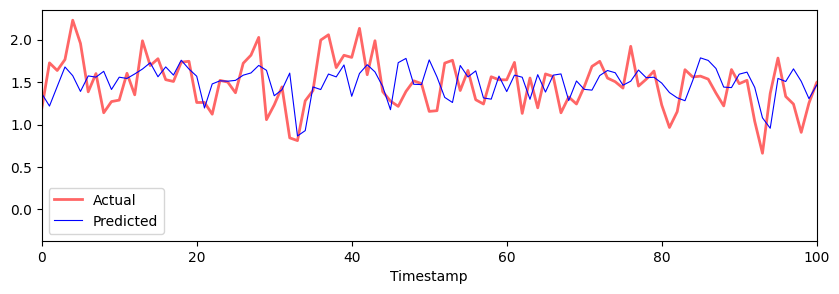

In [28]:
plt.figure(figsize=(10,3))
plt.plot( y_test1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse1 = mean_squared_error(y_test1, y_test_pred1)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse1 = mean_squared_error(y_test1, y_test_pred1, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae1 = mean_absolute_error(y_test1, y_test_pred1)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape1 = np.mean(np.abs((y_test1 - y_test_pred1) / y_test1)) * 100

print("MSE:", mse1)
print("RMSE:", rmse1)
print("MAE:", mae1)
print("MAPE:", mape1)

MSE: 0.07997492840831935
RMSE: 0.28279838827037074
MAE: 0.22300942300851964
MAPE: 37.555887554388725


### Cliente 6

In [30]:
train_size6 = int(len(df_cliente6_idx) * 0.9)
train6, test6 = df_cliente6_idx.iloc[0:train_size6], df_cliente1_idx.iloc[train_size6:len(df_cliente6_idx)]
print("Train size for df_cliente6:", len(train6), "Test size for df_cliente1:", len(test6))

Train size for df_cliente6: 17712 Test size for df_cliente1: 1968


In [31]:
print('Training data shape: ', train6.shape)
print('Test data shape: ', test6.shape)

Training data shape:  (17712, 1)
Test data shape:  (1968, 1)


In [32]:
train6 = scaler.fit_transform(train6)
train6

array([[0.11288257],
       [0.07051971],
       [0.0700887 ],
       ...,
       [0.02713514],
       [0.06386915],
       [0.08611855]])

In [33]:
test6 = scaler.fit_transform(test6)
test6

array([[0.64444269],
       [0.62331481],
       [0.48176068],
       ...,
       [0.6257132 ],
       [0.43721732],
       [0.43844695]])

In [34]:
# Selecting the timesteps

timesteps=5

In [35]:
# Converting data to 2D tensor

train_data_timesteps6=np.array([[j for j in train6[i:i+timesteps]] for i in range(0,len(train6)-timesteps+1)])[:,:,0]
train_data_timesteps6.shape

(17708, 5)

In [36]:
print(train_data_timesteps6[0:5])

[[0.11288257 0.07051971 0.0700887  0.02200258 0.10469481]
 [0.07051971 0.0700887  0.02200258 0.10469481 0.07843332]
 [0.0700887  0.02200258 0.10469481 0.07843332 0.06314019]
 [0.02200258 0.10469481 0.07843332 0.06314019 0.10221818]
 [0.10469481 0.07843332 0.06314019 0.10221818 0.13394836]]


In [37]:
# Converting test data to 2D tensor

test_data_timesteps6=np.array([[j for j in test6[i:i+timesteps]] for i in range(0,len(test6)-timesteps+1)])[:,:,0]
test_data_timesteps6.shape

(1964, 5)

In [38]:
x_train6, y_train6 = train_data_timesteps6[:,:timesteps-1],train_data_timesteps6[:,[timesteps-1]]
x_test6, y_test6 = test_data_timesteps6[:,:timesteps-1],test_data_timesteps6[:,[timesteps-1]]

print(x_train6.shape, y_train6.shape)
print(x_test6.shape, y_test6.shape)

(17708, 4) (17708, 1)
(1964, 4) (1964, 1)


In [39]:
# Definir el modelo SVR con los parámetros proporcionados
model6 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

# Fit model on training data
model6.fit(x_train6, y_train6[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [40]:
#import joblib
#joblib.dump(model6, 'svr_model6.pkl')

In [41]:
# Making predictions

# y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred6 = model6.predict(x_test6).reshape(-1,1)

print( y_test_pred6.shape)

(1964, 1)


In [42]:
#Scaling to original form
# Scaling the predictions
# y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred6 = scaler.inverse_transform(y_test_pred6)

print( len(y_test_pred6))

1964


In [43]:
# Scaling the original values
# y_train = scaler.inverse_transform(y_train)
y_test6 = scaler.inverse_transform(y_test6)

print( len(y_test6))

1964


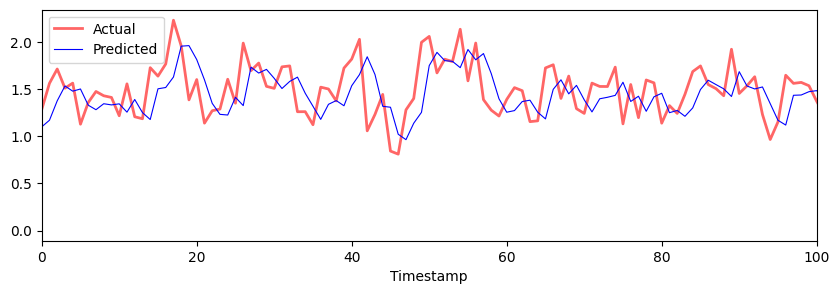

In [44]:
plt.figure(figsize=(10,3))
plt.plot( y_test6, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred6, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse6 = mean_squared_error(y_test6, y_test_pred6)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse6 = mean_squared_error(y_test6, y_test_pred6, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae6 = mean_absolute_error(y_test6, y_test_pred6)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape6 = np.mean(np.abs((y_test6 - y_test_pred6) / y_test6)) * 100

print("MSE:", mse6)
print("RMSE:", rmse6)
print("MAE:", mae6)
print("MAPE:", mape6)

MSE: 0.0847969228156924
RMSE: 0.2911991119761398
MAE: 0.22870414657550725
MAPE: 38.200119477448716


### CLiente 17

In [46]:
train_size17 = int(len(df_cliente17_idx) * 0.9)
train17, test17 = df_cliente17_idx.iloc[0:train_size17], df_cliente17_idx.iloc[train_size17:len(df_cliente17_idx)]
print("Train size for df_cliente17:", len(train17), "Test size for df_cliente17:", len(test17))

Train size for df_cliente17: 17539 Test size for df_cliente17: 1949


In [47]:
print('Training data shape: ', train17.shape)
print('Test data shape: ', test17.shape)

Training data shape:  (17539, 1)
Test data shape:  (1949, 1)


In [48]:
train17 = scaler.fit_transform(train17)
train17

array([[0.11388225],
       [0.0893207 ],
       [0.09440057],
       ...,
       [0.09434467],
       [0.09193139],
       [0.11388225]])

In [49]:
test17 = scaler.fit_transform(test17)
test17

array([[0.25446342],
       [0.84095892],
       [0.67454466],
       ...,
       [0.76394123],
       [0.73560065],
       [0.59014084]])

In [50]:
# Selecting the timesteps

timesteps=24

In [51]:
# Converting data to 2D tensor

train_data_timesteps17=np.array([[j for j in train17[i:i+timesteps]] for i in range(0,len(train17)-timesteps+1)])[:,:,0]
train_data_timesteps17.shape

(17516, 24)

In [52]:
print(train_data_timesteps17[0:5])

[[0.11388225 0.0893207  0.09440057 0.11960539 0.16425092 0.17693321
  0.21142635 0.19094485 0.16894306 0.17695917 0.19459973 0.1584736
  0.17821822 0.18119661 0.15171843 0.17284535 0.20674904 0.1776818
  0.14275794 0.1587681  0.1757544  0.13492606 0.08210316 0.11388225]
 [0.0893207  0.09440057 0.11960539 0.16425092 0.17693321 0.21142635
  0.19094485 0.16894306 0.17695917 0.19459973 0.1584736  0.17821822
  0.18119661 0.15171843 0.17284535 0.20674904 0.1776818  0.14275794
  0.1587681  0.1757544  0.13492606 0.08210316 0.11388225 0.07925947]
 [0.09440057 0.11960539 0.16425092 0.17693321 0.21142635 0.19094485
  0.16894306 0.17695917 0.19459973 0.1584736  0.17821822 0.18119661
  0.15171843 0.17284535 0.20674904 0.1776818  0.14275794 0.1587681
  0.1757544  0.13492606 0.08210316 0.11388225 0.07925947 0.09861942]
 [0.11960539 0.16425092 0.17693321 0.21142635 0.19094485 0.16894306
  0.17695917 0.19459973 0.1584736  0.17821822 0.18119661 0.15171843
  0.17284535 0.20674904 0.1776818  0.14275794 0.

In [53]:
# Converting test data to 2D tensor

test_data_timesteps17=np.array([[j for j in test17[i:i+timesteps]] for i in range(0,len(test17)-timesteps+1)])[:,:,0]
test_data_timesteps17.shape

(1926, 24)

In [54]:
x_train17, y_train17 = train_data_timesteps17[:,:timesteps-1],train_data_timesteps17[:,[timesteps-1]]
x_test17, y_test17 = test_data_timesteps17[:,:timesteps-1],test_data_timesteps17[:,[timesteps-1]]

print(x_train17.shape, y_train17.shape)
print(x_test17.shape, y_test17.shape)

(17516, 23) (17516, 1)
(1926, 23) (1926, 1)


In [55]:
# Definir el modelo SVR con los parámetros proporcionados
model17 = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
# Fit model on training data
model17.fit(x_train17, y_train17[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [56]:
#import joblib
#joblib.dump(model17, 'svr_model17.pkl')

In [57]:
# Making predictions

# y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred17 = model17.predict(x_test17).reshape(-1,1)

print( y_test_pred17.shape)

(1926, 1)


In [58]:
#Scaling to original form
# Scaling the predictions
# y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred17 = scaler.inverse_transform(y_test_pred17)

print( len(y_test_pred17))

1926


In [59]:
# Scaling the original values
# y_train = scaler.inverse_transform(y_train)
y_test17 = scaler.inverse_transform(y_test17)

print( len(y_test17))

1926


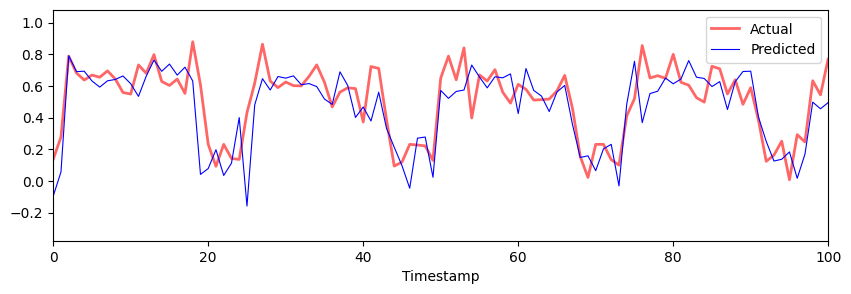

In [60]:
plt.figure(figsize=(10,3))
plt.plot( y_test17, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred17, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse17 = mean_squared_error(y_test17, y_test_pred17)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse17 = mean_squared_error(y_test17, y_test_pred17, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae17 = mean_absolute_error(y_test17, y_test_pred17)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape17 = np.mean(np.abs((y_test17 - y_test_pred17) / y_test17)) * 100

print("MSE:", mse17)
print("RMSE:", rmse17)
print("MAE:", mae17)
print("MAPE:", mape17)

MSE: 0.02920405733080768
RMSE: 0.17089194636028837
MAE: 0.135556373371793
MAPE: 70.19910604427612


In [74]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

timesteps=24

train_data_timesteps17=np.array([[j for j in train17[i:i+timesteps]] for i in range(0,len(train17)-timesteps+1)])[:,:,0]
test_data_timesteps17=np.array([[j for j in test17[i:i+timesteps]] for i in range(0,len(test17)-timesteps+1)])[:,:,0]

x_train17, y_train17 = train_data_timesteps17[:,:timesteps-1],train_data_timesteps17[:,[timesteps-1]]
x_test17, y_test17 = test_data_timesteps17[:,:timesteps-1],test_data_timesteps17[:,[timesteps-1]]

# Definir los parámetros a buscar
param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.1, 0.3, 0.5],
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1]
}

# Crear el modelo SVR
svr = SVR()

# Definir el GridSearchCV con el modelo SVR y los parámetros
grid_search17 = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Entrenar el GridSearchCV con los datos
grid_search17.fit(x_train17, y_train17)  # Asegúrate de tener tus datos X_train, y_train



Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  12.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  12.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  13.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  13.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  14.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  13.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  14.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  16.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  16.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  15.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  14.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  16.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  18.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  18.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   2.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   2.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  27.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  23.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  27.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  34.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  34.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  39.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  33.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  39.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  52.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  53.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  42.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  36.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  41.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 1.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 1.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   7.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   7.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   8.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  11.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   8.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   9.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  12.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  12.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   7.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   7.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   7.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time= 2.4min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time= 1.8min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time= 2.3min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time= 3.3min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time= 3.2min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 3.4min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 2.8min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 3.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 5.9min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 5.8min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 3.7min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 3.0min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 3.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 5.9min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 6.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  25.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  22.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  29.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  39.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  40.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  33.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  25.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  35.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time= 1.0min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time= 1.1min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  27.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  19.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  27.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  58.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  56.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=  11.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=  11.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=  15.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=  21.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=  20.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=  14.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=  10.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=  19.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=  30.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=  29.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=  11.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=  13.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=  21.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=  21.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros encontrados:


NameError: name 'grid_search' is not defined

In [76]:
# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search17.best_params_)

# Obtener el mejor modelo
best_svr17 = grid_search17.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred17 = best_svr17.predict(x_test17)  # Asegúrate de tener tus datos X_test
mse = mean_squared_error(y_test17, y_pred17)
print("Error cuadrático medio en el conjunto de prueba:", mse)

Mejores hiperparámetros encontrados:
{'C': 1, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Error cuadrático medio en el conjunto de prueba: 0.024790234514211695


In [62]:
timesteps=24

train_data_timesteps17=np.array([[j for j in train17[i:i+timesteps]] for i in range(0,len(train17)-timesteps+1)])[:,:,0]
test_data_timesteps17=np.array([[j for j in test17[i:i+timesteps]] for i in range(0,len(test17)-timesteps+1)])[:,:,0]

x_train17, y_train17 = train_data_timesteps17[:,:timesteps-1],train_data_timesteps17[:,[timesteps-1]]
x_test17, y_test17 = test_data_timesteps17[:,:timesteps-1],test_data_timesteps17[:,[timesteps-1]]

# Definir el modelo SVR con los parámetros proporcionados
model17 = SVR(kernel='rbf',gamma=0.1, C=1, epsilon = 0.1)
# Fit model on training data
model17.fit(x_train17, y_train17[:,0])

y_test_pred17 = model17.predict(x_test17).reshape(-1,1)
y_test_pred17 = scaler.inverse_transform(y_test_pred17)
y_test17 = scaler.inverse_transform(y_test17)

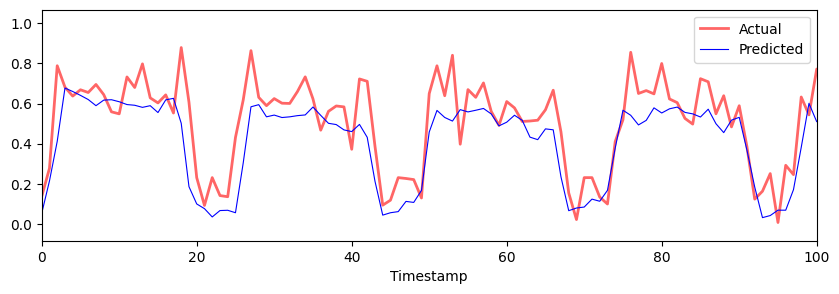

In [63]:
plt.figure(figsize=(10,3))
plt.plot( y_test17, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred17, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse17 = mean_squared_error(y_test17, y_test_pred17)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse17 = mean_squared_error(y_test17, y_test_pred17, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae17 = mean_absolute_error(y_test17, y_test_pred17)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape17 = np.mean(np.abs((y_test17 - y_test_pred17) / y_test17)) * 100

print("MSE:", mse17)
print("RMSE:", rmse17)
print("MAE:", mae17)
print("MAPE:", mape17)

MSE: 0.02544992850413282
RMSE: 0.159530337253241
MAE: 0.12760340963494265
MAPE: 43.72222394840307


In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

timesteps=5

train_data_timesteps6=np.array([[j for j in train6[i:i+timesteps]] for i in range(0,len(train6)-timesteps+1)])[:,:,0]
test_data_timesteps6=np.array([[j for j in test6[i:i+timesteps]] for i in range(0,len(test6)-timesteps+1)])[:,:,0]

x_train6, y_train6 = train_data_timesteps6[:,:timesteps-1],train_data_timesteps6[:,[timesteps-1]]
x_test6, y_test6 = test_data_timesteps6[:,:timesteps-1],test_data_timesteps6[:,[timesteps-1]]

# Definir los parámetros a buscar
param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.1, 0.3, 0.5],
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1]
}

# Crear el modelo SVR
svr = SVR()

# Definir el GridSearchCV con el modelo SVR y los parámetros
grid_search6 = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Entrenar el GridSearchCV con los datos
grid_search6.fit(x_train6, y_train6)  # Asegúrate de tener tus datos X_train, y_train

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search6.best_params_)

# Obtener el mejor modelo
best_svr6 = grid_search6.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred6 = best_svr6.predict(x_test6)  # Asegúrate de tener tus datos X_test
mse = mean_squared_error(y_test6, y_pred6)
print("Error cuadrático medio en el conjunto de prueba:", mse)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   9.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   9.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   9.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=   9.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=   9.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  10.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  10.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   9.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   1.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  11.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  11.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  13.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  12.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  12.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  14.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  12.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  12.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  13.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  13.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   5.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   4.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   2.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   2.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   2.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  19.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  16.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  16.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  19.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  19.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  29.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  25.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  25.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  29.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  31.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  39.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  30.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  31.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  37.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  38.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   8.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   7.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   8.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  11.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   6.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   7.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  10.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  13.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   8.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   9.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  13.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  13.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   6.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   5.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   6.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   7.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   3.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   4.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   7.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   8.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   4.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   8.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   8.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros encontrados:
{'C': 10, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Error cuadrático medio en el conjunto de prueba: 0.0185623216876438


In [65]:
timesteps=5

train_data_timesteps6=np.array([[j for j in train6[i:i+timesteps]] for i in range(0,len(train6)-timesteps+1)])[:,:,0]
test_data_timesteps6=np.array([[j for j in test6[i:i+timesteps]] for i in range(0,len(test6)-timesteps+1)])[:,:,0]

x_train6, y_train6 = train_data_timesteps6[:,:timesteps-1],train_data_timesteps6[:,[timesteps-1]]
x_test6, y_test6 = test_data_timesteps6[:,:timesteps-1],test_data_timesteps6[:,[timesteps-1]]

# Definir el modelo SVR con los parámetros proporcionados
model6 = SVR(kernel='rbf',gamma=0.1, C=10, epsilon = 0.1)
# Fit model on training data
model6.fit(x_train6, y_train6[:,0])

y_test_pred6 = model6.predict(x_test6).reshape(-1,1)
y_test_pred6 = scaler.inverse_transform(y_test_pred6)
y_test6 = scaler.inverse_transform(y_test6)

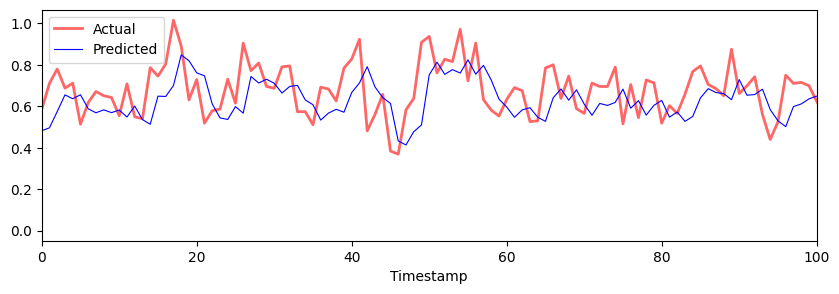

In [66]:
plt.figure(figsize=(10,3))
plt.plot( y_test6, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred6, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse6 = mean_squared_error(y_test6, y_test_pred6)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse6 = mean_squared_error(y_test6, y_test_pred6, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae6 = mean_absolute_error(y_test6, y_test_pred6)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape6 = np.mean(np.abs((y_test6 - y_test_pred6) / y_test6)) * 100

print("MSE:", mse6)
print("RMSE:", rmse6)
print("MAE:", mae6)
print("MAPE:", mape6)

MSE: 0.019056284423224264
RMSE: 0.13804450160446183
MAE: 0.10940210744241478
MAPE: 39.26630129886422


In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

timesteps=18

train_data_timesteps1=np.array([[j for j in train1[i:i+timesteps]] for i in range(0,len(train1)-timesteps+1)])[:,:,0]
test_data_timesteps1=np.array([[j for j in test1[i:i+timesteps]] for i in range(0,len(test1)-timesteps+1)])[:,:,0]

x_train1, y_train1 = train_data_timesteps1[:,:timesteps-1],train_data_timesteps1[:,[timesteps-1]]
x_test1, y_test1 = test_data_timesteps1[:,:timesteps-1],test_data_timesteps1[:,[timesteps-1]]

# Definir los parámetros a buscar
param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.1, 0.3, 0.5],
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.05, 0.1]
}

# Crear el modelo SVR
svr = SVR()

# Definir el GridSearchCV con el modelo SVR y los parámetros
grid_search1 = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Entrenar el GridSearchCV con los datos
grid_search1.fit(x_train1, y_train1)  # Asegúrate de tener tus datos X_train, y_train

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search1.best_params_)

# Obtener el mejor modelo
best_svr1 = grid_search1.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred1 = best_svr1.predict(x_test1)  # Asegúrate de tener tus datos X_test
mse = mean_squared_error(y_test1, y_pred1)
print("Error cuadrático medio en el conjunto de prueba:", mse)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  10.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  11.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  11.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=1, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   3.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ............C=1, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  13.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  14.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  14.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  14.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  14.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  17.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  19.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  19.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  20.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.3, kernel=rbf; total time=  19.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  22.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  23.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  23.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  23.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.01, gamma=0.5, kernel=rbf; total time=  23.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   3.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.1, kernel=rbf; total time=   4.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   4.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.3, kernel=rbf; total time=   5.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   5.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   6.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   6.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=10, epsilon=0.05, gamma=0.5, kernel=rbf; total time=   6.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...........C=10, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   0.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  36.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  40.1s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  39.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  43.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.1, kernel=rbf; total time=  43.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 1.2min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 1.4min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 1.3min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 1.4min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.3, kernel=rbf; total time= 1.4min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 1.7min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 1.9min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 2.0min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 2.0min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.01, gamma=0.5, kernel=rbf; total time= 2.0min


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  10.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  11.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  11.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  12.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.1, kernel=rbf; total time=  12.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  16.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  21.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  21.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  22.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.3, kernel=rbf; total time=  22.8s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  22.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  29.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  29.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  30.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .........C=100, epsilon=0.05, gamma=0.5, kernel=rbf; total time=  29.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.7s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.1, kernel=rbf; total time=   0.9s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.3s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.3, kernel=rbf; total time=   1.2s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   1.0s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   1.4s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   1.6s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..........C=100, epsilon=0.1, gamma=0.5, kernel=rbf; total time=   1.5s


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejores hiperparámetros encontrados:
{'C': 1, 'epsilon': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}
Error cuadrático medio en el conjunto de prueba: 0.01499918225554006


In [ ]:
{'C': 1, 'epsilon': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}
Error cuadrático medio en el conjunto de prueba: 0.01499918225554006

In [68]:
timesteps=18

train_data_timesteps1=np.array([[j for j in train1[i:i+timesteps]] for i in range(0,len(train1)-timesteps+1)])[:,:,0]
test_data_timesteps1=np.array([[j for j in test1[i:i+timesteps]] for i in range(0,len(test1)-timesteps+1)])[:,:,0]

x_train1, y_train1 = train_data_timesteps1[:,:timesteps-1],train_data_timesteps1[:,[timesteps-1]]
x_test1, y_test1 = test_data_timesteps1[:,:timesteps-1],test_data_timesteps1[:,[timesteps-1]]

# Definir el modelo SVR con los parámetros proporcionados
model1 = SVR(kernel='rbf',gamma=0.1, C=1, epsilon = 0.05)
# Fit model on training data
model1.fit(x_train1, y_train1[:,0])

y_test_pred1 = model1.predict(x_test1).reshape(-1,1)
y_test_pred1 = scaler.inverse_transform(y_test_pred1)
y_test1 = scaler.inverse_transform(y_test1)

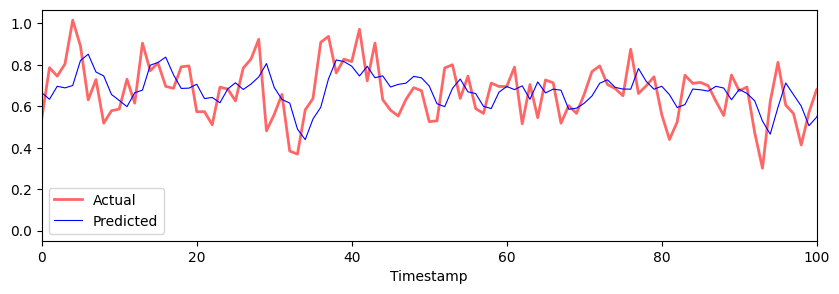

In [86]:
plt.figure(figsize=(10,3))
plt.plot( y_test1, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot( y_test_pred1, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.xlim(0, 100)
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular el Error Cuadrático Medio (MSE)
mse1 = mean_squared_error(y_test1, y_test_pred1)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse1 = mean_squared_error(y_test1, y_test_pred1, squared=False)

# Calcular el Error Absoluto Medio (MAE)
mae1 = mean_absolute_error(y_test1, y_test_pred1)

# Calcular el Error Porcentual Absoluto Medio (MAPE)
mape1 = np.mean(np.abs((y_test1 - y_test_pred1) / y_test1)) * 100

print("MSE:", mse1)
print("RMSE:", rmse1)
print("MAE:", mae1)
print("MAPE:", mape1)

MSE: 0.015398326135443207
RMSE: 0.12408999208414516
MAE: 0.09818329575617436
MAPE: 38.83303116402664


In [69]:
import joblib
joblib.dump(model1, 'svr_model1.pkl')
joblib.dump(model6, 'svr_model6.pkl')
joblib.dump(model17, 'svr_model17.pkl')

['svr_model17.pkl']